In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
dataset = pd.read_csv("heart_disease_uci.csv")

Required Preprocessing (learnt from previous notebooks)

In [3]:
# Handling trestbps outlier
print("Outlier in trestbps feature: ") # all of these outlier findings has been done in previous notebooks
print(dataset[dataset['trestbps']==0])
dataset['trestbps'] = dataset['trestbps'].replace(0, np.nan)
print(dataset['trestbps'].min(skipna = True))

# Handling oldpeak outlier
print("Outlier in oldpeak feature")
print(len(dataset[dataset['oldpeak'] <0]))
dataset['oldpeak']  = dataset['oldpeak'].clip(lower = 0, upper = 6)
print(len(dataset[dataset['oldpeak'] <0]))

# Splitting the dataset
X = dataset.iloc[:,1:-1]
y = dataset.iloc[: , -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("\nNumeric Features are: ")
print(dataset.select_dtypes(include=[np.number]).columns.tolist())

# Transformations

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'mean')),
        ('scaler', StandardScaler())
    ]
)
cat_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('encoder', OneHotEncoder(drop = 'first'))
    ]
)
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

# Applying transformations

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("After transformation, dataset is: ")
print(X_train[:5])
print(X_train.shape)

# creating a map

feature_names = (num_features +
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)))

X_df = pd.DataFrame(X_train, columns = feature_names)
print(X_df.info())

Outlier in trestbps feature: 
      id  age   sex        dataset           cp  trestbps  chol    fbs  \
753  754   55  Male  VA Long Beach  non-anginal       0.0   0.0  False   

    restecg  thalch  exang  oldpeak slope  ca thal  num  
753  normal   155.0  False      1.5  flat NaN  NaN    3  
80.0
Outlier in oldpeak feature
12
0

Numeric Features are: 
['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
After transformation, dataset is: 
[[ 9.02412547e-01  1.57774920e-15 -2.54935123e-01 -6.88473319e-01
   2.00217983e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 3.47761857e-02  1.00702194e+00  0.00000000e+00 -6.09262363e-01
  -8.55320196e-01  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.0000000

<Axes: ylabel='count'>

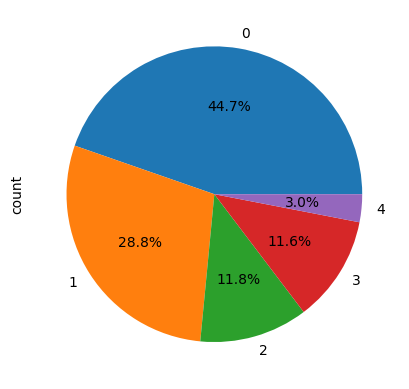

In [4]:
dataset['num'].value_counts().plot.pie(autopct = '%1.1f%%')

 Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

log_reg = LogisticRegression(random_state=42, max_iter = 1000)
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)
y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

Logistic Regression Results:
Accuracy: 0.5489

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.87      0.77        75
           1       0.43      0.50      0.46        54
           2       0.17      0.04      0.06        25
           3       0.38      0.31      0.34        26
           4       0.00      0.00      0.00         4

    accuracy                           0.55       184
   macro avg       0.33      0.34      0.33       184
weighted avg       0.48      0.55      0.51       184


Confusion Matrix:
[[65  9  0  1  0]
 [23 27  1  3  0]
 [ 2 15  1  7  0]
 [ 4 11  3  8  0]
 [ 0  1  1  2  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Decision Trees

In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, max_depth=5)  # Limit depth to prevent overfitting
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

# Evaluation
print("Decision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Results:
Accuracy: 0.5598

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        75
           1       0.47      0.50      0.48        54
           2       0.36      0.32      0.34        25
           3       0.17      0.04      0.06        26
           4       0.00      0.00      0.00         4

    accuracy                           0.56       184
   macro avg       0.34      0.35      0.33       184
weighted avg       0.49      0.56      0.51       184



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest

X_train shape: (736, 20)
X_test shape: (184, 20)
Random Forest Results:
Accuracy: 0.5924

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83        75
           1       0.50      0.52      0.51        54
           2       0.32      0.24      0.27        25
           3       0.37      0.27      0.31        26
           4       0.00      0.00      0.00         4

    accuracy                           0.59       184
   macro avg       0.39      0.39      0.38       184
weighted avg       0.55      0.59      0.57       184


Top 10 Feature Importances:
    feature_index  importance
4               4    0.142853
0               0    0.137749
3               3    0.133545
2               2    0.114851
1               1    0.109497
12             12    0.039853
6               6    0.038144
10             10    0.032313
5               5    0.029841
13             13    0.028045

Confusion Matrix:
[[68  5  2  0  0]
 [

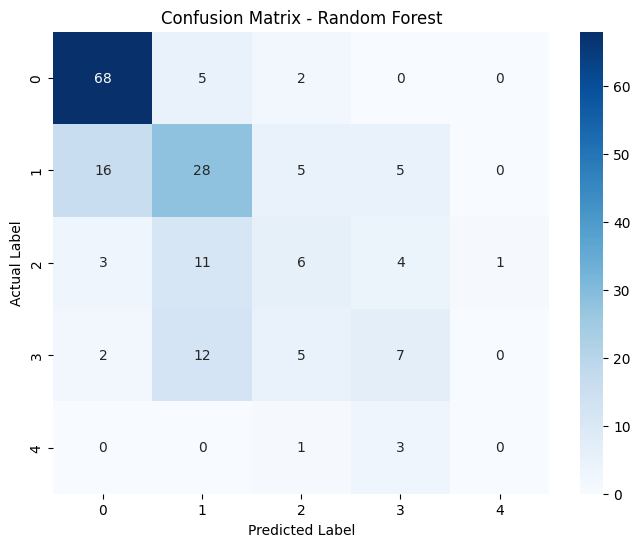

In [12]:
from sklearn.ensemble import RandomForestClassifier

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    n_jobs=-1,
    class_weight = 'balanced'
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_proba_rf  = rf.predict_proba(X_test)
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

feature_importance = pd.DataFrame({
    'feature_index': range(X_train.shape[1]),
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

plt.figure(figsize=(8, 6)) # Set the figure size
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.show()

In [8]:
# First install if needed: pip install xgboost
try:
    import xgboost as xgb

    # Initialize and train
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)


    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


    print("XGBoost Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb))

except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:42:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
Accuracy: 0.6196

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.82        75
           1       0.52      0.54      0.53        54
           2       0.50      0.32      0.39        25
           3       0.43      0.35      0.38        26
           4       0.00      0.00      0.00         4

    accuracy                           0.62       184
   macro avg       0.44      0.42      0.42       184
weighted avg       0.59      0.62      0.60       184



In [10]:
# Import necessary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compare performance - Dictionary of your model names and their predictions
models = {
    'Logistic Regression': y_pred_log,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf
}

# Add XGBoost and LightGBM if available
if 'y_pred_xgb' in locals():
    models['XGBoost'] = y_pred_xgb
if 'y_pred_lgb' in locals():
    models['LightGBM'] = y_pred_lgb

# Print detailed comparison
print("Model Comparison:")
print("=" * 65)
# Print header
print(f"{'Model':<20} | {'Accuracy':<8} | {'Precision':<8} | {'Recall':<8} | {'F1-Score':<8}")
print("-" * 65)

# Calculate and print metrics for each model - USING 'weighted' AVERAGE FOR MULTICLASS
for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted')  # Changed for multiclass
    rec = recall_score(y_test, preds, average='weighted')      # Changed for multiclass
    f1 = f1_score(y_test, preds, average='weighted')           # Changed for multiclass
    print(f"{name:<20} | {acc:.4f}    | {prec:.4f}    | {rec:.4f}    | {f1:.4f}")

# Create comprehensive comparison DataFrame
results_list = []
for name, preds in models.items():
    results_list.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, average='weighted'),  # Changed
        'Recall': recall_score(y_test, preds, average='weighted'),        # Changed
        'F1': f1_score(y_test, preds, average='weighted')                 # Changed
    })

results_df = pd.DataFrame(results_list)

# Sort by your preferred metric, e.g., F1-Score
results_df = results_df.sort_values('F1', ascending=False)

print("\nRanked Models by F1-Score:")
print("=" * 65)
print(results_df.to_string(index=False))

Model Comparison:
Model                | Accuracy | Precision | Recall   | F1-Score
-----------------------------------------------------------------
Logistic Regression  | 0.5489    | 0.4841    | 0.5489    | 0.5059
Decision Tree        | 0.5598    | 0.4882    | 0.5598    | 0.5123
Random Forest        | 0.5924    | 0.5531    | 0.5924    | 0.5684
XGBoost              | 0.6196    | 0.5884    | 0.6196    | 0.5979

Ranked Models by F1-Score:
              Model  Accuracy  Precision   Recall       F1
            XGBoost  0.619565   0.588445 0.619565 0.597850
      Random Forest  0.592391   0.553136 0.592391 0.568441
      Decision Tree  0.559783   0.488248 0.559783 0.512303
Logistic Regression  0.548913   0.484109 0.548913 0.505866


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m